# Lab Session #5
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Robbe De Beck [01902805], Robbe De Muynck [01908861]
<br>
<font color=blue>Academic Year:</font> 2022-2023

# Module 3: Brunel network

In this practical, you will simulate a network of sparsely connected identical Leaky-Integrate-and-Fire neurons. 

This model is based on the paper by [Brunel 2000](https://link.springer.com/article/10.1023/A:1008925309027) and is also discussed in [Neuronal Dynamics](http://neuronaldynamics.epfl.ch), see eg. Figure 13.7. 

We will show that a large network of neurons consisting of a group of excitatory and a group of inhibitory neurons that receive external input is capable of producing a rich dynamics. The parameters that we will vary to trigger different states are (1) the driving frequency of the external population and (2) the relative strength of inhibition vs excitation (g). 

To do so, we will follow two strategies both relying on the BRIAN package: the first strategy is to create our own network from scratch. This will allow you to get acquainted with the BRIAN package and will prepare you for the second strategy. Here, you will use a pre-defined spiking network (included in the BRIAN package), but you will have to make sure you understand its input and outputs in order to induce the correct behaviour. 


We start by ensuring all packages are loaded. Make sure to have installed the [Brian Package](https://briansimulator.org/) 

In [13]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools, spike_tools
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

## Step 1.1. Initialising the NeuronGroup instance

We start by defining a NeuronGroup instance. You can find the documentation [here](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.groups.neurongroup.NeuronGroup.html) 

A NeuronGroup instance takes as input the number of neurons, the dynamics of a single neuron 'model', the length of the refractory period and the integration method. Note that initialising the NeuronGroup will not yet run the simulation. Running the simulation will be done in the upcoming blocks once we have added all details to the network. 

The input parameters of the NeuronGroup instance should be: 
- number of neurons: N_Excit (4000) +N_Inhib (1000)
- the model should model the LIF dynamics
- the model should reset at a threshold v = v_reset (10 mV)
- the neurons should have an absolute refractory period (2ms)
- integration method should be linear

What is the default firing threshold? 

In [14]:
# Import neurodynex3 LIF dynamics & check default values
from neurodynex3.brunel_model import LIF_spiking_network
print('default firing threshold:\t', LIF_spiking_network.FIRING_THRESHOLD)
print('default membrane timescale:\t', LIF_spiking_network.MEMBRANE_TIME_SCALE, '\n')

b2.start_scope()

# Define input parameters
N_Excit = 4000
N_Inhib = 1000

v_rest = 0*b2.mV
v_reset = 10*b2.mV
abs_refractory_period = 2*b2.ms

firing_threshold = LIF_spiking_network.FIRING_THRESHOLD
membrane_time_scale = LIF_spiking_network.MEMBRANE_TIME_SCALE
# b2.defaultclock.dt = 0.1*b2.ms

lif_dynamics = """
dv/dt = (v_rest - v)/membrane_time_scale : volt
"""
# Initialize NeuronGroup instance
network = NeuronGroup(
    N_Excit+N_Inhib, model=lif_dynamics,
    threshold='v > firing_threshold', refractory=abs_refractory_period,
    method='linear',reset='v = v_reset')

print(network)
print(network.v)

default firing threshold:	 20. mV
default membrane timescale:	 20. ms 

100. us
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
<neurongroup_1.v: array([0., 0., 0., ..., 0., 0., 0.]) * volt>


<div class="alert alert-success">
<span style="color:black">

**A1.1 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->
    
The default firing threshold is 20 mV.

<!-- \end{tcolorbox} -->
    
</span>

## Step 1.2. Add network structure
Now that we have created a group of neurons, we will define how they are connected. In order to connect neurons to each other, we first need to distinguish the two neuronal populations (the excitatory and inhibitory population). In order to define the first N_Excit neurons to be excitatory and the remaining part to be inhibitory, you can simply use the following code snippet. 

In [15]:
# Define neuron connections: split excitatory & inhibitory population
excitatory_population = network[:N_Excit]
inhibitory_population = network[N_Excit:]

Now, we need to define two types of synapses: excitatory and inhibitory synapses. Allow for a synaptic delay of 1.5*b2.ms and use a random connection probability of 0.1. You can find the documentation [here](https://brian2.readthedocs.io/en/stable/user/synapses.html) 
In order to follow the notations in the book, please use following notation and default values: 

What is the "target" network? 

In [16]:
# Define synapse parameters
w0 = 0.1*b2.mV
g = 4.0
J_excit = w0
J_inhib = -g*w0
synaptic_delay = 1.5*b2.ms
connection_probability = 0.1

# Define excitatory & inhibitory synapses
exc_synapses = Synapses(excitatory_population, target=network, on_pre="v += J_excit * (rand() < connection_probability)", delay=synaptic_delay)
exc_synapses.connect(p=connection_probability)
inhib_synapses = Synapses(inhibitory_population, target=network, on_pre="v += J_inhib * (rand() < connection_probability)", delay=synaptic_delay)
inhib_synapses.connect(p=connection_probability)

<div class="alert alert-success">
<span style="color:black">

**A1.2 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->
    
The "target" network is composed of the complete population of excitatory and inhibitory neurons.

<!-- \end{tcolorbox} -->
    
</span>

## Step 1.3. Enter external Poisson input
Next, you can excite the network through an externally applied Poisson input, by using [Poisson Input](https://brian2.readthedocs.io/en/stable/reference/brian2.input.poissoninput.PoissonInput.html). Start with N = 1000 external Poisson neurons at an input rate of 13 Hz with a connectivity strength w = w0. 



In [17]:
# Define PoissonInput parameters
poisson_input_rate = 13*b2.Hz
N_extern = 1000
w_external = w0

# Initialize PoissonInput instance
external_poisson_input = PoissonInput(target=network, target_var="v", N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)


## Step 1.4. Add monitors 
In the final step before running the simulation we will add some monitors that allows us to assess the simulated network once the simulation has finished. In order to do so, we will monitor a random selection of 100 neurons and the use the [PopulationRateMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html), [SpikeMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html) and [StateMonitor](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.statemonitor.StateMonitor.html). 

Sample 200 of all neurons involved. 

In [18]:
# Define monitors to assess the network simulation
monitored_subset_size = 200
random.seed(123)
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)

# rate_monitor: records instantaneous firing rates, averaged across the neurons of the NeuronGroup.
rate_monitor = PopulationRateMonitor(network)
# spike_monitor: records spikes from the NeuronGroup.
spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
# voltage_monitor: records values of the state variable v (voltage) during a simulation
voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)


## Step 1.5. Run the simulation
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted. 


In [19]:
# Run simulation for sim_time
sim_time=500.*b2.ms
b2.run(sim_time)

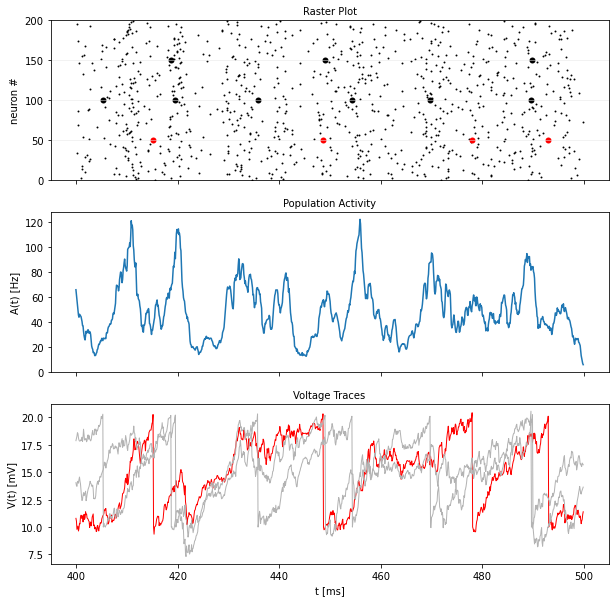

In [20]:
# Plot simulation results
plot_tools.plot_network_activity(rate_monitor, spike_monitor,
                                 voltage_monitor, spike_train_idx_list=idx_monitored_neurons,
                                 figure_size=(10, 10))
plt.show()

Access the data in rate_monitor, spike_monitor, voltage_monitor

First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window. 

You can the time axis from rate_monitor.t

In [21]:
# Get time axis
ts = rate_monitor.t / b2.ms
t_min, t_max = 350, 500
idx_rate = np.where((t_min <= ts) & (ts < t_max))
print(rate_monitor.rate)

<ratemonitor_1.rate: array([ 0.,  0.,  0., ..., 10., 10.,  4.]) * hertz>


Now, vary the window width across which the rate is averaged and write down your observations (do plot!). 

Window width: 0.5 ms
Mean of rate accross time window: 49.34 Hz

Window width: 5.0 ms
Mean of rate accross time window: 49.26 Hz

Window width: 10.0 ms
Mean of rate accross time window: 49.01 Hz

Window width: 20.0 ms
Mean of rate accross time window: 48.38 Hz



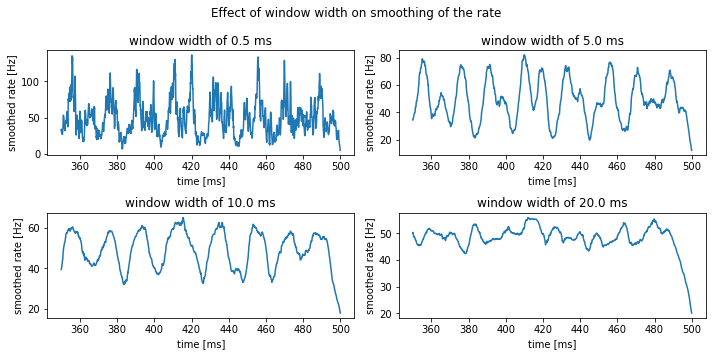

In [22]:
# Investigate the effect window width on smoothing of the rate
window_widths = [0.5, 5, 10, 20]*b2.ms

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('Effect of window width on smoothing of the rate')

for i in range(0, 4):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    axs[i//2, i%2].plot(ts[idx_rate], smoothed_rates[idx_rate])
    axs[i//2, i%2].set_xlabel('time [ms]')
    axs[i//2, i%2].set_ylabel('smoothed rate [Hz]')
    axs[i//2, i%2].set_title(f'window width of {window_widths[i]*1000} ms')

    print(f"""Window width: {window_widths[i]*1000} ms
Mean of rate accross time window: {np.mean(smoothed_rates[idx_rate]):.2f} Hz
""")

plt.tight_layout()
plt.show()

Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  

In [23]:
eventtrains = spike_monitor.event_trains()
# eventtrains is a dictionary mapping neuron indices to spike trains

ISIs = []
for train in eventtrains.values():
    ISI = np.diff(train)
    if len(ISI) > 1:
        ISIs.append(ISI)
mean = np.mean([np.mean(ISI) for ISI in ISIs])
print(f"""Mean time between two subsequent spikes: {mean*1e3:.1f} ms""")

Mean time between two subsequent spikes: 25.5 ms


<div class="alert alert-success">
<span style="color:black">

**A1.5 Answer** 

<!-- \begin{tcolorbox}[colback=green!5] -->

The plot constructed with the *plot_network_activity()* method visualizes the results of a network simulation: a dot-raster plot for each monitored neuron that shows its spike-trains, the monitored population activity and the voltage-traces.

The *rate_monitor.rate* describes the instantaneous firing rates at every timepoint in the simulation, averaged across the neurons of the network.

Next, one could vary the window width across which the firing rate is averaged and investigate the effect on the interpretability of the resulting plot.

The plot using a 0.5 ms window width shows many high-frequency oscillations that are not present in the plots using 5 ms or greater window widths. When using a 5 ms window width, the mean rate was found to be `??` spikes/s. Increasing the window width results in a smoother plot with fewer high-frequency oscillations. The 5 ms and 10 ms window widths capture a similar signal, while the 20 ms window width does not capture the signal well: here, the signal is smoothed out too much in order to still distinguish meaningful trends in the spiking behaviour.

When selecting a window width, there is a trade-off between capturing high-frequency information (with a small window width) and obtaining a clearer overall trend of the signal (with a larger window width). As the window width increases, the overall amplitude decreases, as high amplitude values are averaged out.

The *spike_monitor* records the spikes of the monitored neurons. The spikes can be accessed by calling the *spike_trains()* method, which returns a dictionary, mapping neuron indices to spike trains. The mean time between two subsequent spikes is calculated and printed in the code cell above.


<!-- \end{tcolorbox} -->
    
</span>

# 2. The pre-implemented Brunel network

Import the LIF_spiking_network function from neurodynex3.brunel_model and use this function to simulate a network consisting of 10000 excitatory neurons, 2500 inhibitory neurons and 1000 external neurons. 

Further, 
- w0 = 0.1 mV
- total simulated time of 500 ms
- the membrane time scale can be put to default (LIF_spiking_network.MEMBRANE_TIME_SCALE)
- the same goes for the firing threshold (LIF_spiking_network.FIRING_THRESHOLD)
- monitored_subset = 50
- synaptic delay is 1.5ms 

We will vary two parameters: g (an input parameter to simulate_brunel_network) and, second, the firing frequency of the external neurons $\nu_{extern}$. The latter should be expressed as a ratio multiplied with $\nu_{threshold}$. The frequency $\nu_{threshold}$ is the minimal poisson rate in the external neuronal population required to elicit firing in the network in the absence of any feedback. 

According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 

\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}

Does this expression make sense? 

For starters, you can use g=6 and $\nu_{extern} = 4\nu_{threshold}$

Calculate $\nu_{threshold}$ in function of the parameters mentioned above and the corresponding $\nu_{extern}$. And run the simulation. Make sure to output rate_monitor, spike_monitor, voltage_monitor and monitored_spike_idx.

Make sure to start each simulation with a "b2.start_scope()" statement. 

In [30]:
from neurodynex3.brunel_model import LIF_spiking_network
b2.start_scope()

# Default values
FIRING_THRESHOLD = LIF_spiking_network.FIRING_THRESHOLD # 20.*b2.mV
MEMBRANE_TIME_SCALE = LIF_spiking_network.MEMBRANE_TIME_SCALE # 20.*b2.ms
# b2.defaultclock.dt = 0.1*b2.ms

# Set parameters
N_Excit = 10000
N_Inhib = 2500
N_extern = 1000

w0 = 0.1*b2.mV
sim_time = 500*b2.ms
monitored_subset_size = 50
SYNAPTIC_DELAY = 1.5*b2.ms
g = 6

# Determine nu_threshold & nu_extern
nu_threshold = FIRING_THRESHOLD / (N_extern*w0*MEMBRANE_TIME_SCALE)
nu_extern = 4*nu_threshold
print(f"""
nu_threshold =\t{nu_threshold} Hz
nu_extern    =\t{nu_extern} Hz
""")


nu_threshold =	10.0 Hz
nu_extern    =	40.0 Hz



In [31]:
# Run simulation
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=10000, N_Inhib=2500, N_extern=1000, w0=0.1*b2.mV, sim_time=500*b2.ms,\
                                                 monitored_subset_size=50,g=g,poisson_input_rate=nu_extern)

Plot the output using "plot_network_activity", make sure to add the "t_min" and "t_max" parameter and increase the figure size to figure_size=(10,10). 

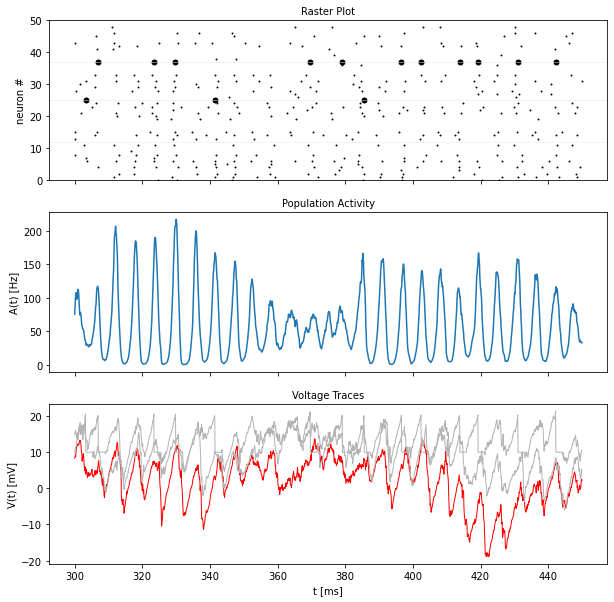

In [32]:
# Plot simulation results
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=300*b2.ms, t_max=450*b2.ms,\
                                 figure_size=(10, 10))
plt.show()

The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 


Window width: 0.5 ms
Mean of rate accross time window: 57.67 Hz

Window width: 5.0 ms
Mean of rate accross time window: 57.44 Hz

Window width: 20.0 ms
Mean of rate accross time window: 57.53 Hz



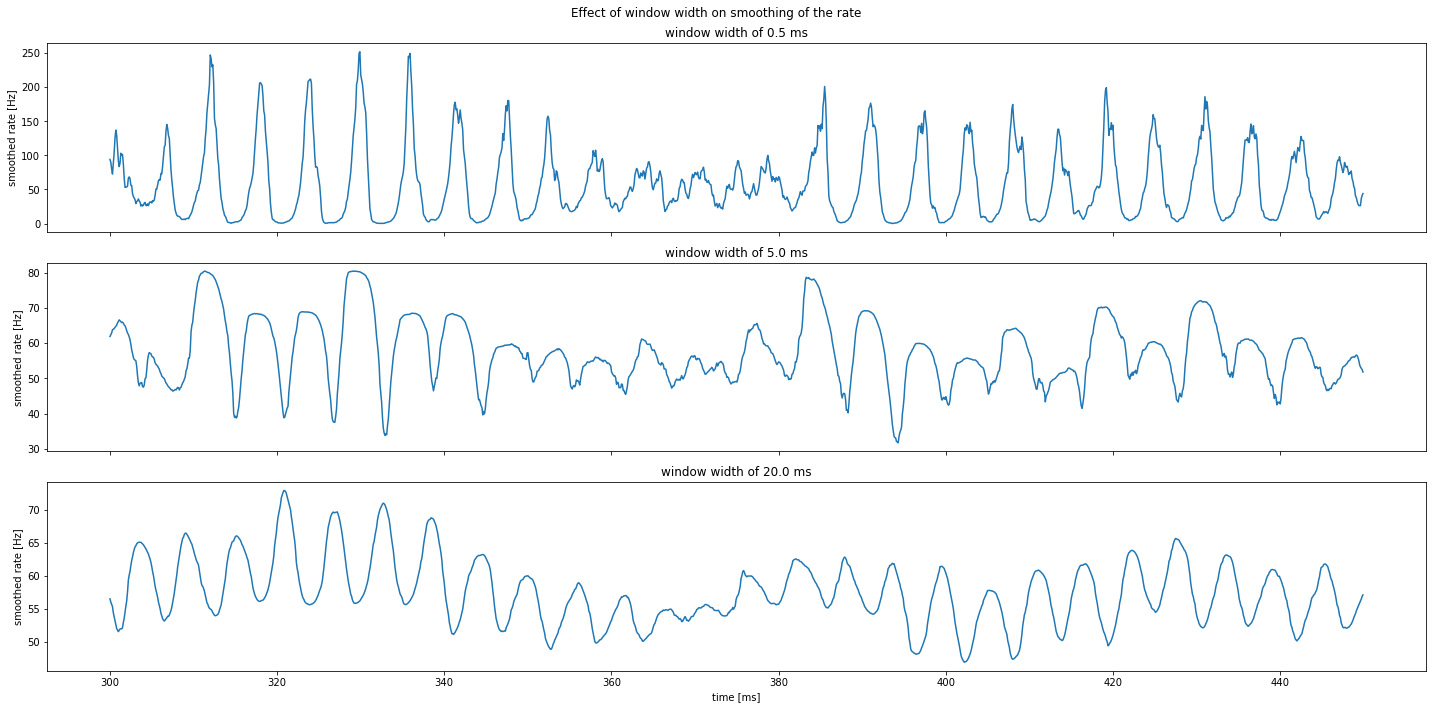

In [33]:
# Get time axis
ts = rate_monitor.t / b2.ms
t_min, t_max = 300, 450
idx_rate = (t_min <= ts) * (ts < t_max)

# Investigate the effect window width on smoothing of the rate
window_widths = [0.5,5,20]*b2.ms

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True)
fig.suptitle('Effect of window width on smoothing of the rate')

for i, window in enumerate(window_widths):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window)/b2.Hz
    
    axs[i].plot(ts[idx_rate], smoothed_rates[idx_rate])
    axs[i].set_ylabel('smoothed rate [Hz]')
    axs[i].set_title(f'window width of {window*1000} ms')

    print(f"""Window width: {window*1000} ms
Mean of rate accross time window: {np.mean(smoothed_rates[idx_rate]):.2f} Hz
""")

axs[-1].set_xlabel('time [ms]')
plt.tight_layout()
plt.show()

Next, we want to assess the global frequency content in rate_monitor. We know that if we have a time signal of 0.5 seconds, the maximal frequency resolution is 2 Hz. Be aware that Welch' method as implemented will chop the data in different pieces (to enable the averaging of the spectrum) yielding a smaller frequency resolution.  

Start by smoothing the rate with a window of 0.5 ms and calculate the spectrum using [signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). What is the sampling frequency fs? 

Plot the spectrum. What is the frequency resolution (look at np.diff(f)[0]). Can you explain how signal.welch arrives at this frequency resolution if you know that it - by default - includes 256 samples and if you check the integration time constant (typically 0.05 ms, but check b2.defaultclock.dt) that you used for the simulation? 

What happens if you impose nperseg = 256*8? 

What happens if you impose nfft = 10000 ? (Answer: you interpolate the spectrum). 


Sampling frequency fs		= 10000.0 Hz
Integration time constant	= 0.1 ms
--------------------------------------------------------------
Welch frequency resolution			= 39.0625 Hz
Welch frequency resolution (nperseg=256*8)	= 4.8828125 Hz
Welch frequency 'resolution' (nfft=10000)	= 1.0 Hz



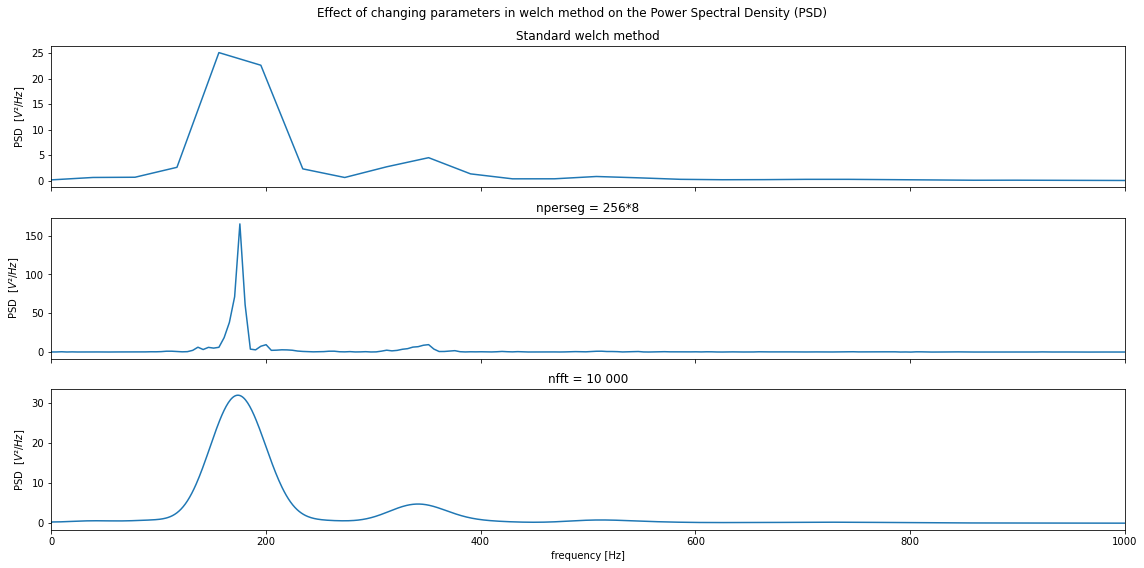

In [56]:
# Assess global frequency content in rate_monitor
from scipy.signal import welch

# Smooth rate (window = 0.5 ms)
smoothed_rates = rate_monitor.smooth_rate(window="flat", width=0.5*b2.ms)/b2.Hz
Fs = 1/(ts[1]-ts[0])*1000 # [Hz]

# Calculate spectrum (welch method): determine frequency resolution
freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
freq_res = np.diff(freqs)[0]

freqs_nperseg, smoothed_rates_spectrum_nperseg = welch(smoothed_rates, fs=Fs, nperseg=256*8)
freq_res_nperseg = np.diff(freqs_nperseg)[0]

freqs_nfft, smoothed_rates_spectrum_nfft = welch(smoothed_rates, fs=Fs, nfft=10000)
freq_res_nfft = np.diff(freqs_nfft)[0]

# Print: comparison of sampling frequency with frequency resolution
print(f"""
Sampling frequency fs\t\t= {Fs} Hz
Integration time constant\t= {b2.defaultclock.dt*1000} ms
--------------------------------------------------------------
Welch frequency resolution\t\t\t= {freq_res} Hz
Welch frequency resolution (nperseg=256*8)\t= {freq_res_nperseg} Hz
Welch frequency 'resolution' (nfft=10000)\t= {freq_res_nfft} Hz
""")

# Plots: effect of changing parameters in welch method
fig, axs = plt.subplots(3, 1, figsize=(16,8), sharex=True)

axs[0].plot(freqs, smoothed_rates_spectrum)
axs[1].plot(freqs_nperseg, smoothed_rates_spectrum_nperseg)
axs[2].plot(freqs_nfft, smoothed_rates_spectrum_nfft)

fig.suptitle('Effect of changing parameters in welch method on the Power Spectral Density (PSD)')
axs[-1].set_xlabel('frequency [Hz]')

axs[0].set_title('Standard welch method')
axs[1].set_title('nperseg = 256*8')
axs[2].set_title('nfft = 10 000')
for ax in axs:
    ax.set_ylabel('PSD  [$V²/Hz$]')
    ax.set_xlim([0, 1000])

plt.tight_layout()
plt.show()

We will now use the machinery provided by BRIAN to calculate and plot the power spectrum. BRIAN takes a slightly different approach. BRIAN starts from a desired frequency resolution, a desired number of windows over which the spectrum should be averaged and an initial time segment that should be ignored. Based on these desiredata, the minimal simulation length is calculated. 

Example: if we want a frequency resolution of 5 Hz, we need time windows of 200 ms. If we assume non-overlapping time windows and a number of averages the total simulated signal should be k*200ms. 

In this case, we have simulated 0.5 seconds of data. If we aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz, what is then the maximal number of windows we can include? 

In [58]:
# Adjusted version of (corrupted) get_population_activity_power_spectrum() method
def get_population_activity_power_spectrum(
        rate_monitor, delta_f, k_repetitions, T_init=100*b2.ms, subtract_mean_activity=False):
    """
    Computes the power spectrum of the population activity A(t) (=rate_monitor.rate)

    Args:
        rate_monitor (RateMonitor): Brian2 rate monitor. rate_monitor.rate is the signal being
            analysed here. The temporal resolution is read from rate_monitor.clock.dt
        delta_f (Quantity): The desired frequency resolution.
        k_repetitions (int): The data rate_monitor.rate is split into k_repetitions which are FFT'd
            independently and then averaged in frequency domain.
        T_init (Quantity): Rates in the time interval [0, T_init] are removed before doing the
            Fourier transform. Use this parameter to ignore the initial transient signals of the simulation.
        subtract_mean_activity (bool): If true, the mean value of the signal is subtracted. Default is False

    Returns:
        freqs, ps, average_population_rate
    """
    data = rate_monitor.rate/b2.Hz
    delta_t = rate_monitor.clock.dt
    f_max = 1./(2. * delta_t)
    N_signal = int(2 * f_max / delta_f)
    T_signal = N_signal * delta_t
    N_init = int(T_init/delta_t)
    N_required = k_repetitions * N_signal + N_init
    N_data = len(data)

    # print("N_data={}, N_required={}".format(N_data,N_required))
    if (N_data < N_required):
        err_msg = "Inconsistent parameters. k_repetitions require {} samples." \
                  " rate_monitor.rate contains {} samples.".format(N_required, N_data)
        raise ValueError(err_msg)
    if N_data > N_required:
        # print("drop samples")
        data = data[:N_required]
    # print("length after dropping end:{}".format(len(data)))
    data = data[N_init:]
    # print("length after dropping init:{}".format(len(data)))
    average_population_rate = np.mean(data)
    if subtract_mean_activity:
        data = data - average_population_rate
    average_population_rate *= b2.Hz
    data = data.reshape(k_repetitions, N_signal)  # reshape into one row per repetition (k)
    k_ps = np.abs(np.fft.fft(data))**2
    ps = np.mean(k_ps, 0)
    # normalize
    ps = ps * delta_t / N_signal  # TODO: verify: subtract 1 (N_signal-1)?
    freqs = np.fft.fftfreq(N_signal, delta_t)
    ps = ps[:int((N_signal/2))]
    freqs = freqs[:int((N_signal/2))]
    return freqs, ps, average_population_rate

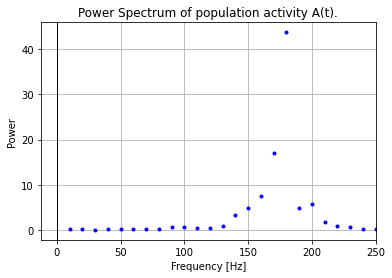

In [62]:
# Compute population activity PSD
delta_f = 10*b2.Hz
k = 4
T_init = 99*b2.ms + b2.defaultclock.dt; 
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)

# Plot population activity
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)
plt.show()

<div class="alert alert-success">
<span style="color:black">

**2 Answer** 

The expression for $\nu_{threshold}$ above (1) makes sense. It relates the threshold firing rate $\nu_{threshold}$ of a neuron to the external input received by the neuron: the number of external inputs $N_{extern}$, the strength of the synapses $w_0$ and the membrane time constant $\tau_m$. The parameter $\theta$ is the firing threshold (here: 20 mV).
This expression is derived based on the assumption that the neuron receives input from a large number of other neurons, and that the input is weak and uncorrelated.

As in exercise 1, the network activity plots show the same expected behaviour.
The mean time between spikes also appears to be slightly less than 20ms, as observed in the raster plot. The smoothed rate with a window width of 5ms seems to give the best results, for the same reasons mentioned in the previous exercise. During the investigated period (300ms-450ms), peaks in the rate can be observed clearly, with an average interval of 15-20ms between peaks.

When compared to the results from the previous exercise, on can appreciate that the rate follows a less oscillatory shape for the simulation with the pre-implemented Brunel network, in comparison with the first approach.

To calculate the spectrum, we first smooth the rate with a window of 0.5 ms, and then use the signal.welch function to compute the power spectral density. The default value of nperseg is 256, meaning that the signal is chopped into 256 sample segments before computing the spectrum. Here, the integration time constant (b2.defaultclock.dt) used for the simulation is 0.1 ms, resulting in a sampling frequency of 1/(0.1 ms) = 10 000 Hz.

The frequency resolution of the spectrum can be calculated as Δf = fs / N, where N is the number of samples in each segment. With the default nperseg value of 256, the frequency resolution is Δf = 10 000 Hz / 256 = 39.0625 Hz. This means that the spectrum can distinguish between frequencies that are at least 39.0625 Hz apart.

If we increase the value of nperseg to 256*8, the number of samples in each segment is increased, resulting in a smaller frequency resolution of Δf = 4.8828125 Hz. This means that the spectrum can distinguish between frequencies that are at least 4.8828125 Hz apart.

If we set nfft to 10 000, the length of the FFT used to compute the spectrum is set to 10 000, which is larger than the default value of nperseg. This causes the spectrum to be interpolated, resulting in a lower frequency resolution of Δf = 10 000 Hz / 10 000 = 1 Hz. This means that the spectrum can distinguish between frequencies that are at least 1 Hz apart. Although the spectrum has a lower frequency resolution, it appears smoother than the one with a frequency resolution of 4.8828125 Hz (nperseg=256*8) because of the interpolation.

----------------------------------

To calculate the power spectrum using the brian package, we need to choose the number of windows or segments to chop the data into. In this case, we have simulated 0.5 seconds of data. We aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz.
Taking these parameters into account, the maximal number of windows is k = 4, based on the following reasoning:

The simulation time was originally 500 ms, but the first 99 ms are not used, leaving us with 401 ms of data. We want a frequency resolution of 10 Hz, which corresponds to time windows of 100 ms. The number of windows is equal to the simulation time divided by the window width: k = t_sim / w_window. Substituting the values, we get k = 401 ms / 100 ms = 4.
Therefore, to calculate the power spectrum with a frequency resolution of 10 Hz using the brian package, we need to chop the data into four windows of 100 ms each.
</span>

## 3 Explore the dynamics. 
Repeat the steps in ##2 for the following set of parameters: 

(A) g = 3, $\nu_{extern}/\nu_{threshold} = 2$ 

(B) g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

(C) g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Describe what you observe.

In [69]:
def dynamics_explorer(g, nu_extern):
    b2.start_scope()
    rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
        LIF_spiking_network.simulate_brunel_network(N_Excit=10000, N_Inhib=2500, N_extern=1000, w0=0.1*b2.mV, sim_time=500*b2.ms,\
                                                    monitored_subset_size=50,g=g,poisson_input_rate=nu_extern)

    plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                    voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                    t_min=300*b2.ms, t_max=450*b2.ms,\
                                    figure_size=(10, 10))
    plt.show()

    # Get time axis
    ts = rate_monitor.t / b2.ms
    t_min, t_max = 300, 450
    idx_rate = (t_min <= ts) * (ts < t_max)

    # Investigate the effect window width on smoothing of the rate
    window_widths = [0.5,5,20]*b2.ms

    fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True)
    fig.suptitle('Effect of window width on smoothing of the rate')

    for i, window in enumerate(window_widths):
        smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window)/b2.Hz
        
        axs[i].plot(ts[idx_rate], smoothed_rates[idx_rate])
        axs[i].set_ylabel('smoothed rate [Hz]')
        axs[i].set_title(f'window width of {window*1000} ms')

        print(f"""Window width: {window*1000} ms
Mean of rate accross time window: {np.mean(smoothed_rates[idx_rate]):.2f} Hz
""")
    axs[-1].set_xlabel('time [ms]')
    plt.tight_layout()
    plt.show()

    # Smooth rate (window = 0.5 ms)
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=0.5*b2.ms)/b2.Hz
    Fs = 1/(ts[1]-ts[0])*1000 # [Hz]

    # Calculate spectrum (welch method): determine frequency resolution
    freqs, smoothed_rates_spectrum = welch(smoothed_rates, fs=Fs)
    freq_res = np.diff(freqs)[0]

    freqs_nperseg, smoothed_rates_spectrum_nperseg = welch(smoothed_rates, fs=Fs, nperseg=256*8)
    freq_res_nperseg = np.diff(freqs_nperseg)[0]

    freqs_nfft, smoothed_rates_spectrum_nfft = welch(smoothed_rates, fs=Fs, nfft=10000)
    freq_res_nfft = np.diff(freqs_nfft)[0]

    # Print: comparison of sampling frequency with frequency resolution
    print(f"""
Sampling frequency fs\t\t= {Fs} Hz
Integration time constant\t= {b2.defaultclock.dt*1000} ms
--------------------------------------------------------------
Welch frequency resolution\t\t\t= {freq_res} Hz
Welch frequency resolution (nperseg=256*8)\t= {freq_res_nperseg} Hz
Welch frequency 'resolution' (nfft=10000)\t= {freq_res_nfft} Hz
""")

    # Plots: effect of changing parameters in welch method
    fig, axs = plt.subplots(3, 1, figsize=(16,8), sharex=True)

    axs[0].plot(freqs, smoothed_rates_spectrum)
    axs[1].plot(freqs_nperseg, smoothed_rates_spectrum_nperseg)
    axs[2].plot(freqs_nfft, smoothed_rates_spectrum_nfft)

    fig.suptitle('Effect of changing parameters in welch method on the Power Spectral Density (PSD)')
    axs[-1].set_xlabel('frequency [Hz]')

    axs[0].set_title('Standard welch method')
    axs[1].set_title('nperseg = 256*8')
    axs[2].set_title('nfft = 10 000')
    for ax in axs:
        ax.set_ylabel('PSD  [$V²/Hz$]')
        ax.set_xlim([0, 1000])

    plt.tight_layout()
    plt.show()

    # Compute population activity PSD
    delta_f = 10*b2.Hz
    k = 4
    T_init = 99*b2.ms + b2.defaultclock.dt; 
    pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)

    # Plot population activity
    plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)
    plt.show()
    return None

## A : g = 3, $\nu_{extern}/\nu_{threshold} = 2$

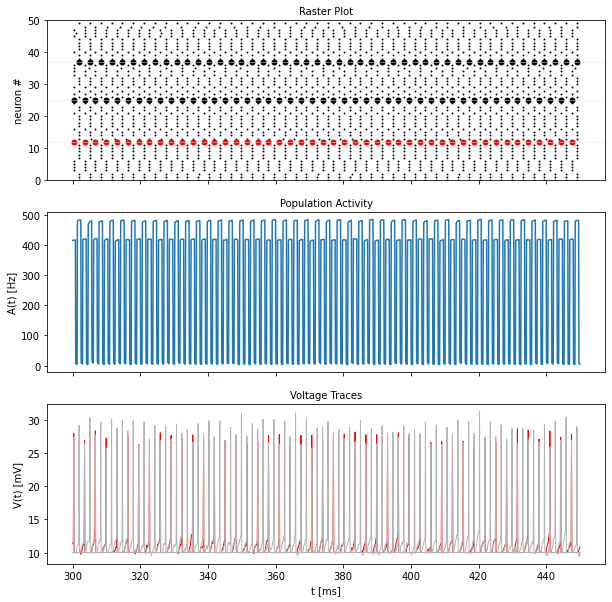

Window width: 0.5 ms
Mean of rate accross time window: 311.42 Hz

Window width: 5.0 ms
Mean of rate accross time window: 310.59 Hz

Window width: 20.0 ms
Mean of rate accross time window: 310.64 Hz



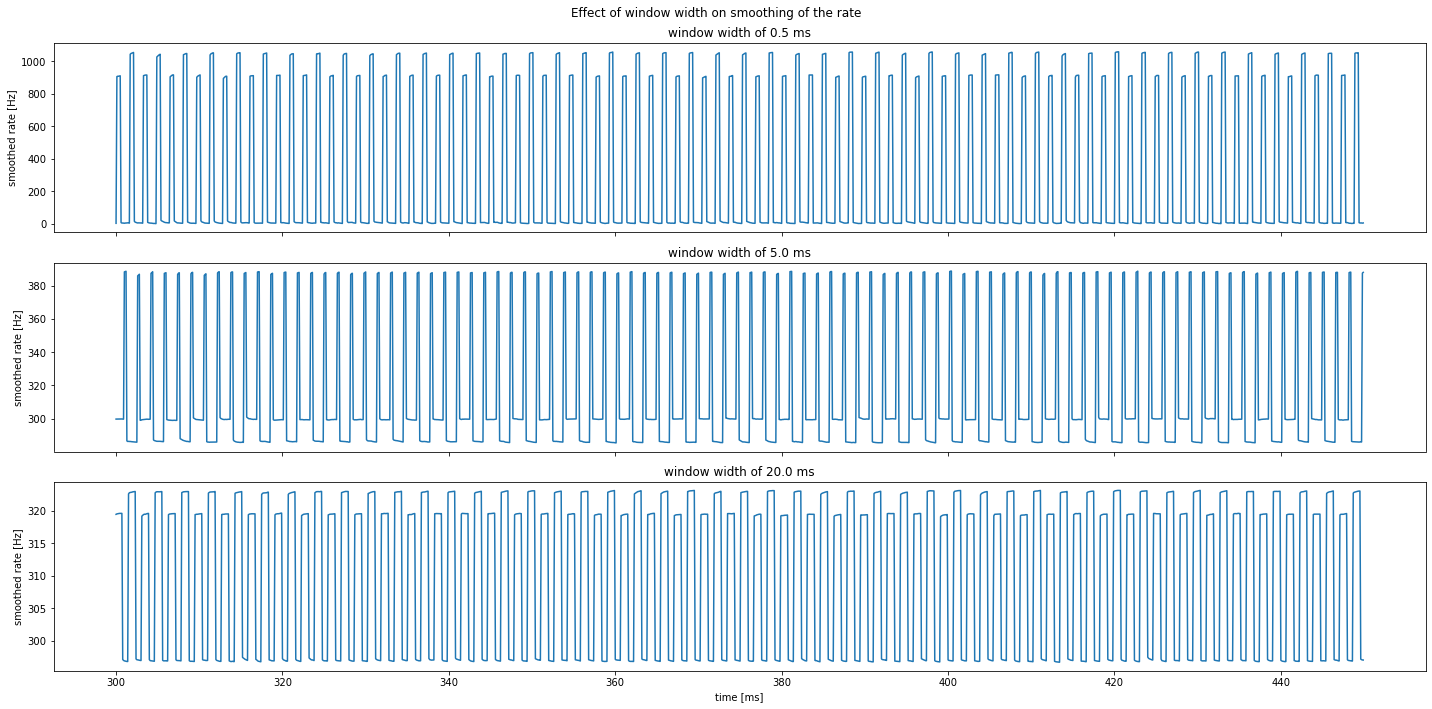


Sampling frequency fs		= 10000.0 Hz
Integration time constant	= 0.1 ms
--------------------------------------------------------------
Welch frequency resolution			= 39.0625 Hz
Welch frequency resolution (nperseg=256*8)	= 4.8828125 Hz
Welch frequency 'resolution' (nfft=10000)	= 1.0 Hz



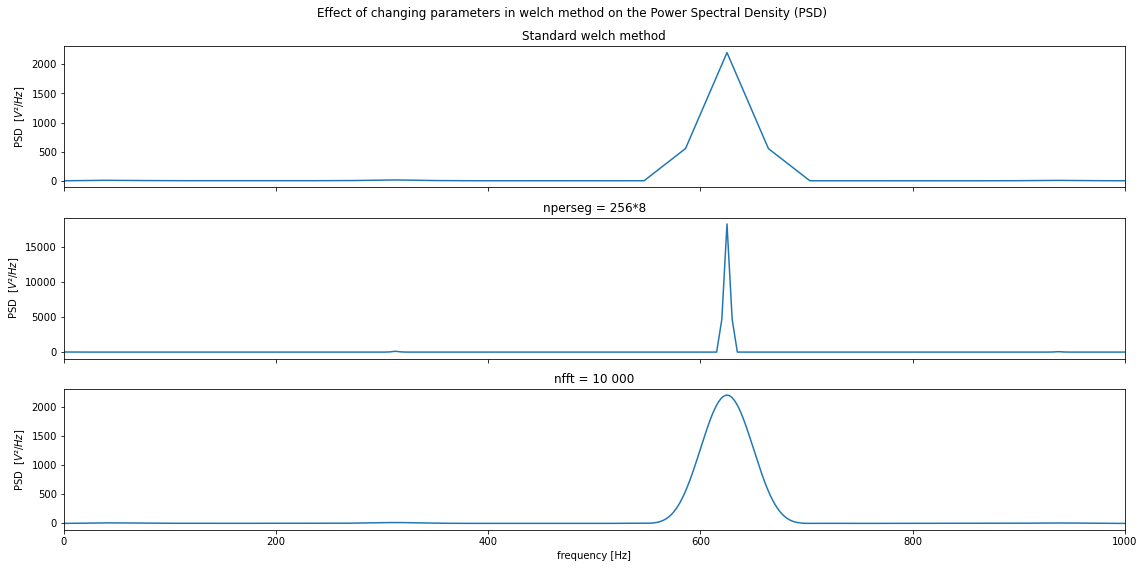

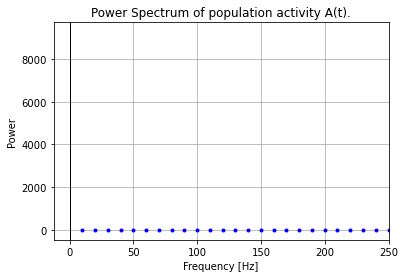

In [70]:
g = 3
nu_threshold = FIRING_THRESHOLD / (N_extern*w0*MEMBRANE_TIME_SCALE)
nu_extern = 2*nu_threshold

dynamics_explorer(g, nu_extern)

<div class="alert alert-success">
<span style="color:black">

**3A Answer** 

The parameter g is the inhibitory strength and $\nu_{extern}$ is the firing frequency of the external neurons.

The network settles into a synchronous regular (SR) state when excitation dominates inhibition and synaptic time distributions are sharply peaked. In this state, neurons tend to be almost fully synchronized in a few clusters, behaving as oscillators. The activity in this state appears to be very regular, with the group of excitatory and inhibitory neurons spiking in an alternating manner. The power spectrum also exhibits a sharp peak, occurring around 620 Hz, despite the mean firing rate being around 311 spikes/s. This is because two clusters, the inhibitory and excitatory, fire in an alternating pattern.

Overall, the network exhibits strong synchronization with regularly firing neurons when excitation dominates inhibition.
</span>

## B : g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

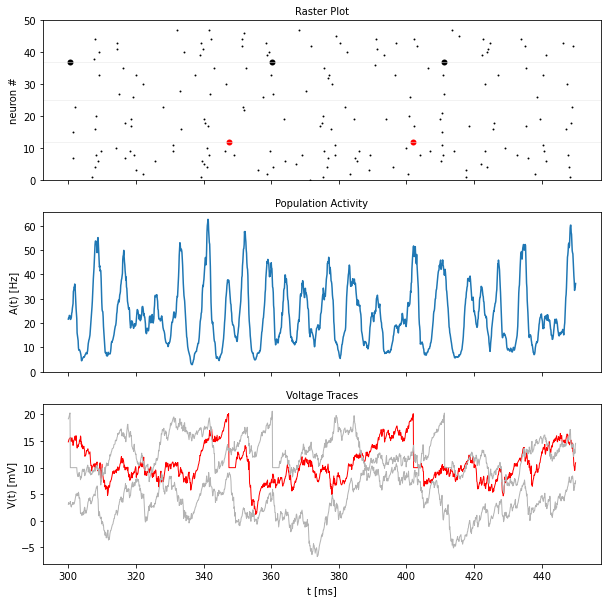

Window width: 0.5 ms
Mean of rate accross time window: 23.32 Hz

Window width: 5.0 ms
Mean of rate accross time window: 23.19 Hz

Window width: 20.0 ms
Mean of rate accross time window: 23.15 Hz



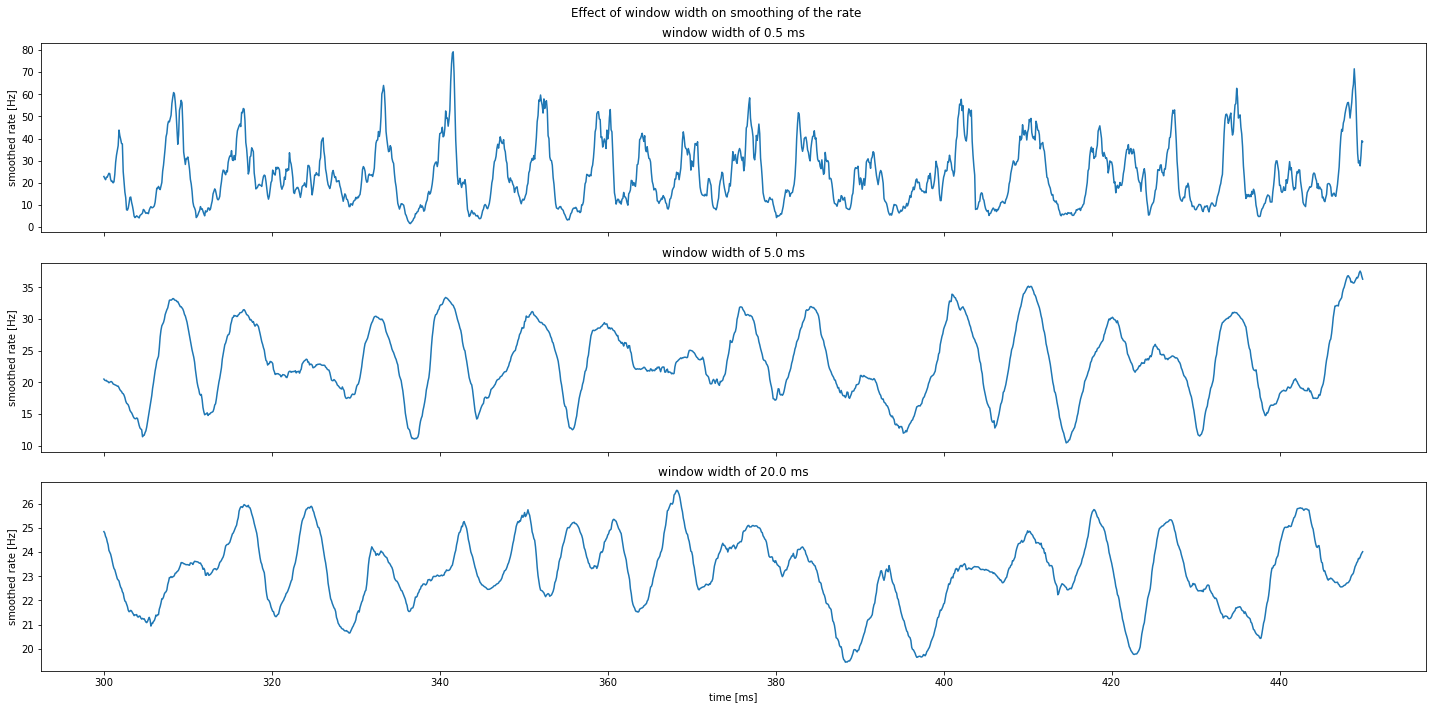


Sampling frequency fs		= 10000.0 Hz
Integration time constant	= 0.1 ms
--------------------------------------------------------------
Welch frequency resolution			= 39.0625 Hz
Welch frequency resolution (nperseg=256*8)	= 4.8828125 Hz
Welch frequency 'resolution' (nfft=10000)	= 1.0 Hz



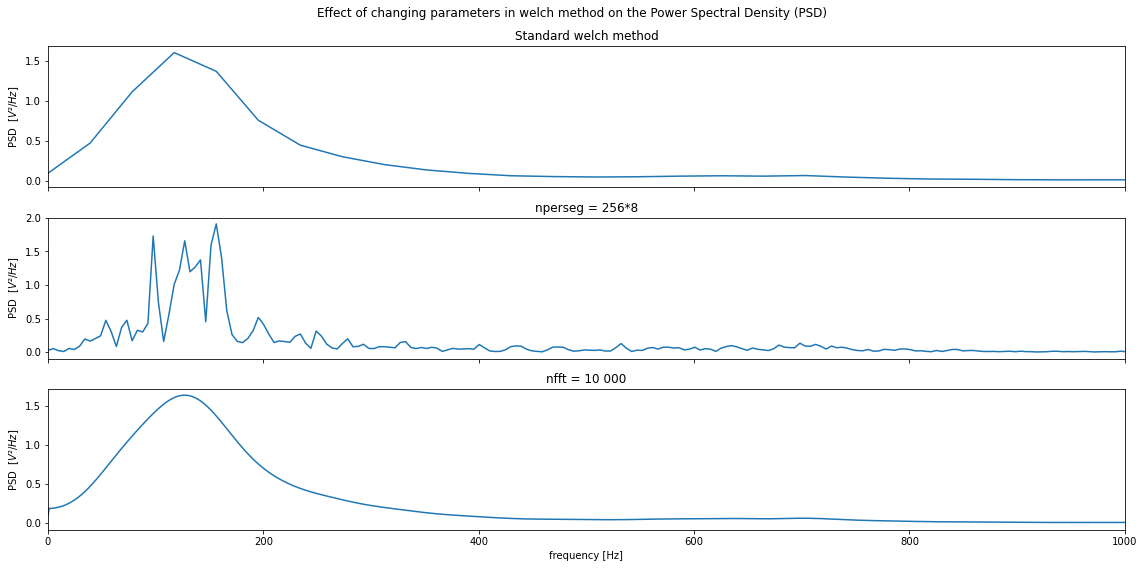

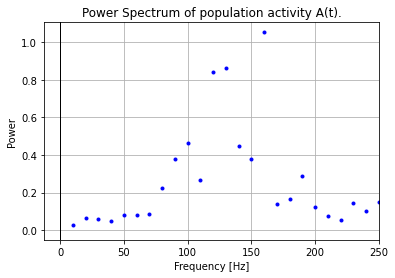

In [71]:
g = 6
nu_threshold = FIRING_THRESHOLD / (N_extern*w0*MEMBRANE_TIME_SCALE)
nu_extern = 2*nu_threshold

dynamics_explorer(g, nu_extern)

<div class="alert alert-success">
<span style="color:black">

**3B Answer** 

The results show a similar pattern as for the parameters used in exercise 2, with a similarity between the spiking patterns of the different neurons. We thus conclude that this similarity probably depends on the value of g the most.

This simulation brings the neurons in the asynchronous irregular state. The oscillations of the power spectrum are strongly damped.

Spiking is irregular due to an increased importance of the inhibitory population (increasing g from 3 to 6).

For this combination of parameters, the system settles into a state where global activity exhibits strongly damped oscillations and neurons fire irregularly. Hence, inhibition dominates and the external frequency is moderate. The mean rate
is much lower than in the previous cases (around 23 Hz). The power spectrum is damped.

</span>

## C : g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

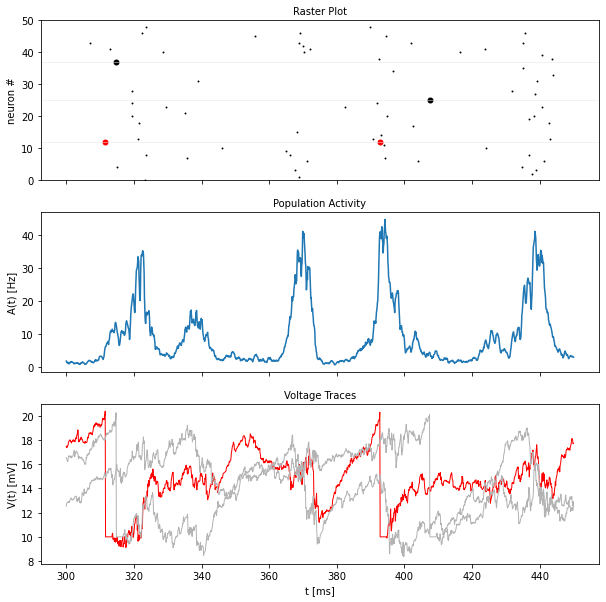

Window width: 0.5 ms
Mean of rate accross time window: 9.12 Hz

Window width: 5.0 ms
Mean of rate accross time window: 9.12 Hz

Window width: 20.0 ms
Mean of rate accross time window: 9.10 Hz



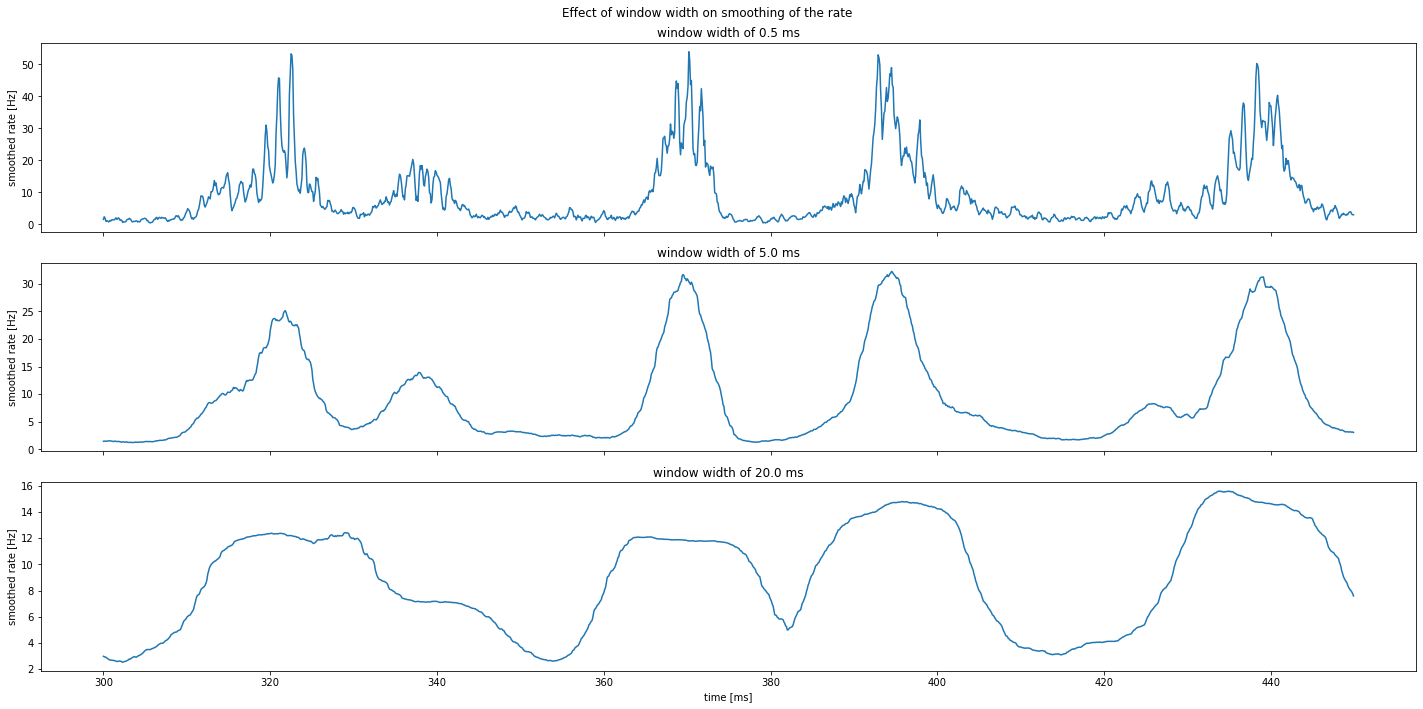


Sampling frequency fs		= 10000.0 Hz
Integration time constant	= 0.1 ms
--------------------------------------------------------------
Welch frequency resolution			= 39.0625 Hz
Welch frequency resolution (nperseg=256*8)	= 4.8828125 Hz
Welch frequency 'resolution' (nfft=10000)	= 1.0 Hz



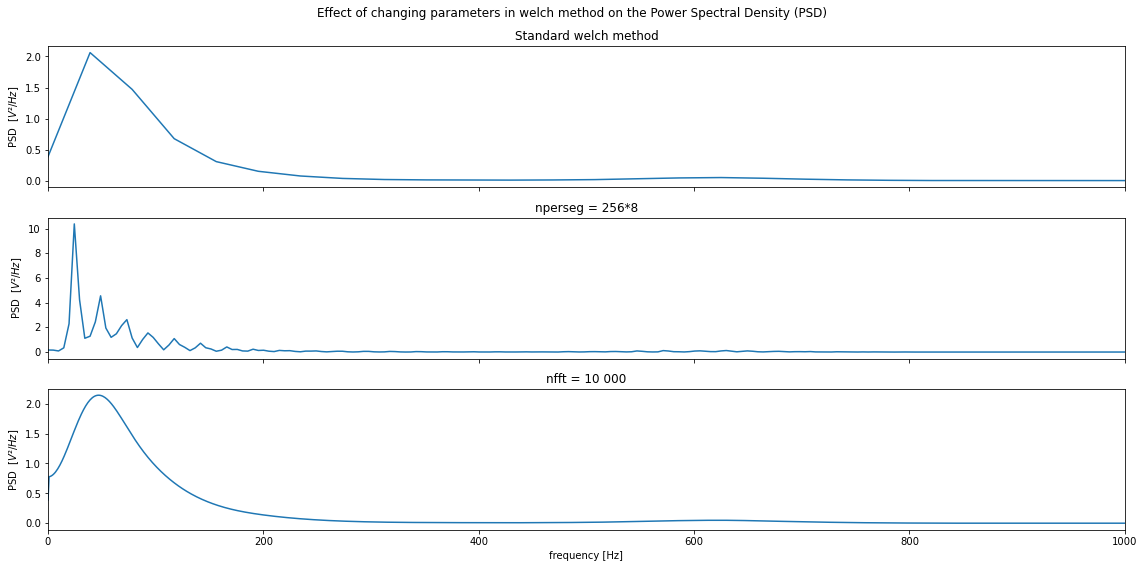

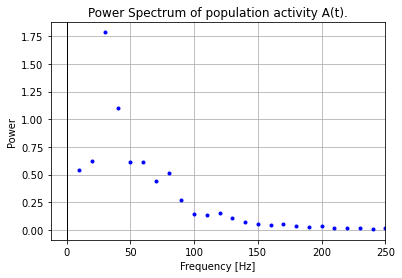

In [72]:
g = 4.5
nu_threshold = FIRING_THRESHOLD / (N_extern*w0*MEMBRANE_TIME_SCALE)
nu_extern = 0.95*nu_threshold

dynamics_explorer(g, nu_extern)

<div class="alert alert-success">
<span style="color:black">

**3C Answer** 

The combination of a moderate g with a very low $\nu_{extern}$ results in a synchronous irregular state with slow oscillations. There is very low individual neuron firing rates when inhibition dominates and the $\nu_{extern}$ is smaller than but close to $\nu_{threshold}$. The mean spiking rate is even lower (around 9 Hz).

After spiking, the inhibitory neurons dominate again and all spiking stops. After some time, the influence of the external neurons will build up again.
In conclusion, there is synchronicity because there is spiking at the same time but there are large intervals between the spiking events.
</span>